### Human TF analysis
###### last updated 2022-05-31
This notebook analyzes all human TFs and generates panels for Figure 5 in the metapredict V2 paper.

This notebook requires [metapredict](https://metapredict.readthedocs.io/en/latest/) and [shephard](https://shephard.readthedocs.io/en/latest/). Both packages were developed by the Holehouse lab and can be installed using `pip` via

    pip install metapredict, shephard


In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


In [2]:
from shephard import interfaces 
from shephard.apis import uniprot
import metapredict as meta

In [3]:
# Read in the set of human transcription factors as a SHEPHARD Proteome object

P = uniprot.uniprot_fasta_to_proteome('human_TFs_full.fasta')

In [4]:
# set to True if we want to write the human TF uniprot IDs out
WRITE_UIDS = False

if WRITE_UIDS:
    # write out UIDs
    fh = open('UID.txt','w')
    for protein in P.proteins:
        fh.write(f"{protein}\n")
    fh.close()    


In [5]:
# if set to True, we we compute disorder regions from scratch
# if set to False, we will simply read previously computed disorder regions in and
# annotate the Proteome
# If recomputing this will take a couple of minutes to execute...
RECOMPUTE = True

if RECOMPUTE:

    for protein in P:
        disorder = meta.predict_disorder_domains(protein.sequence)
        protein.add_track('disorder', values=disorder.disorder)


        for d in disorder.disordered_domain_boundaries:
            protein.add_domain(d[0]+1, d[1], 'IDR')


        disorder = meta.predict_disorder_domains(protein.sequence, legacy=True)
        protein.add_track('disorder_legacy', values=disorder.disorder)

        for d in disorder.disordered_domain_boundaries:
            protein.add_domain(d[0]+1, d[1], 'IDR_legacy')
    
    
    interfaces.si_domains.write_domains(P, 'data/shprd_domains_IDRs.tsv')
    interfaces.si_tracks.write_all_values_tracks_single_file(P, 'data/shprd_tracks_IDRs.tsv') 
    interfaces.si_protein_attributes.write_protein_attributes(P,'data/shprd_protein_attributes.tsv')
else:
    interfaces.si_domains.add_domains_from_file(P, 'data/shprd_domains_IDRs.tsv')
    interfaces.si_tracks.add_tracks_from_file(P, 'data/shprd_tracks_IDRs.tsv', mode='values')
    interfaces.si_protein_attributes.add_protein_attributes_from_file(P,'data/shprd_protein_attributes.tsv')
        
    

### Compute fraction of disorder 
The cell below cycles through each TF and computes t

In [6]:
fraction_disordered = []
fraction_disordered_legacy = []

for protein in P:
    
    
    # generates a list with the length of each IDR in the protein
    IDR_lengths = [len(d) for d in protein.domains if d.domain_type == 'IDR' ]
    
    # calculates the fraction of the protein in the IDR
    fraction_disordered.append(np.sum(IDR_lengths)/len(protein))
    
    # same logic but for IDRs defined by the legacy mode
    fraction_disordered_legacy.append(np.sum([len(d) for d in protein.domains if d.domain_type == 'IDR_legacy' ])/len(protein))
    
    

### Violin plot of disorder
The cell below generates and saves a violin plot of fractional disorder for the two predictors

meta NOT subset; don't know how to subset; dropped


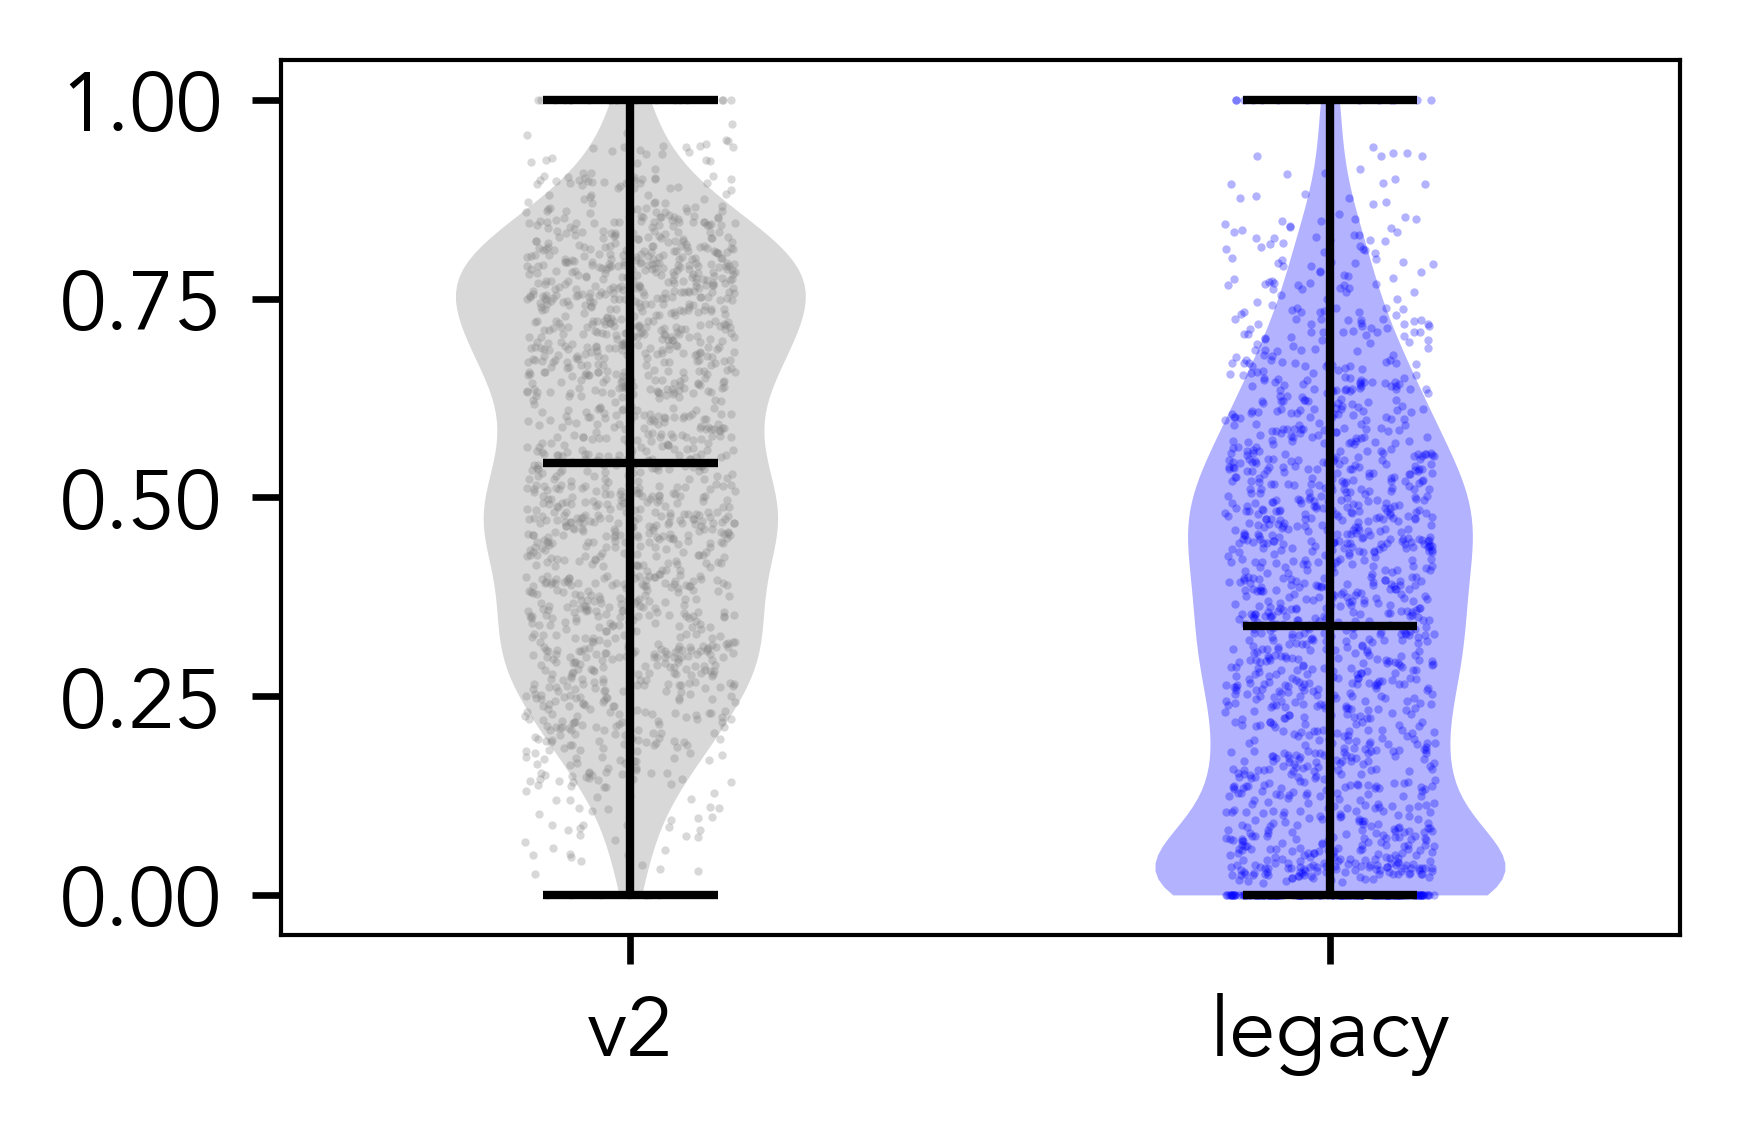

In [7]:
figure(num=None, figsize=(3, 2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


count = len(fraction_disordered)
fraction_disordered
plt.plot(np.array([1]*count)+(np.random.random(count)-0.5)*0.3, fraction_disordered,'.',  color='grey', alpha=0.3, ms=2, mew=0)

plt.plot(np.array([2]*count)+(np.random.random(count)-0.5)*0.3, fraction_disordered_legacy, '.b', alpha=0.3, ms=2, mew=0)

plt.xlim([0,3])
parts = ax.violinplot([fraction_disordered, fraction_disordered_legacy], showmeans=True)

bodies_new = parts['bodies'][0]
bodies_new.set_color('grey')
bodies_new.set_linewidth(0)

bodies_new = parts['bodies'][1]
bodies_new.set_color('blue')
bodies_new.set_linewidth(0)


for partname in ('cbars','cmins','cmaxes','cmeans'):

    parts[partname].set_color('k')
    parts[partname].set_edgecolor('k')
    parts[partname].set_linewidth(1)

plt.xlim([0.5,2.5])    
plt.xticks([1,2],['v2','legacy'])

plt.tight_layout()
plt.savefig('figures/fraction_disordered.pdf')


In [8]:
# sort the fraction disorders in both modes...
fraction_disordered.sort(reverse=True)
fraction_disordered_legacy.sort(reverse=True)


meta NOT subset; don't know how to subset; dropped


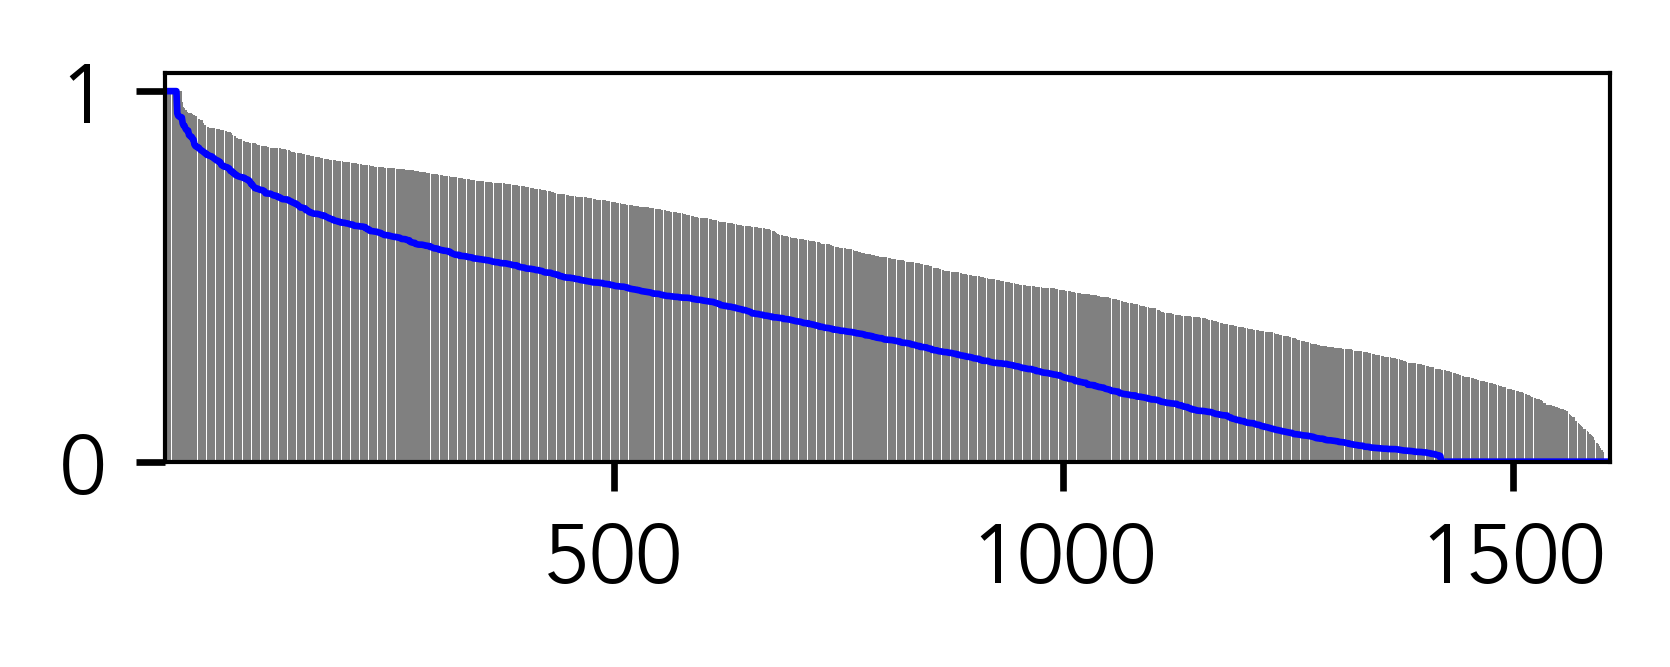

In [9]:
figure(num=None, figsize=(3, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()

idx = np.arange(1,len(fraction_disordered)+1)
plt.bar(idx, fraction_disordered, width=0.9, color='grey')

plt.plot(idx, fraction_disordered_legacy, color='blue',linewidth=0.8)
plt.xlim(1,idx[-1])
plt.tight_layout()
plt.savefig('figures/fraction_disordered_sorted.pdf')


### Show fraction disorder using V2 only

meta NOT subset; don't know how to subset; dropped


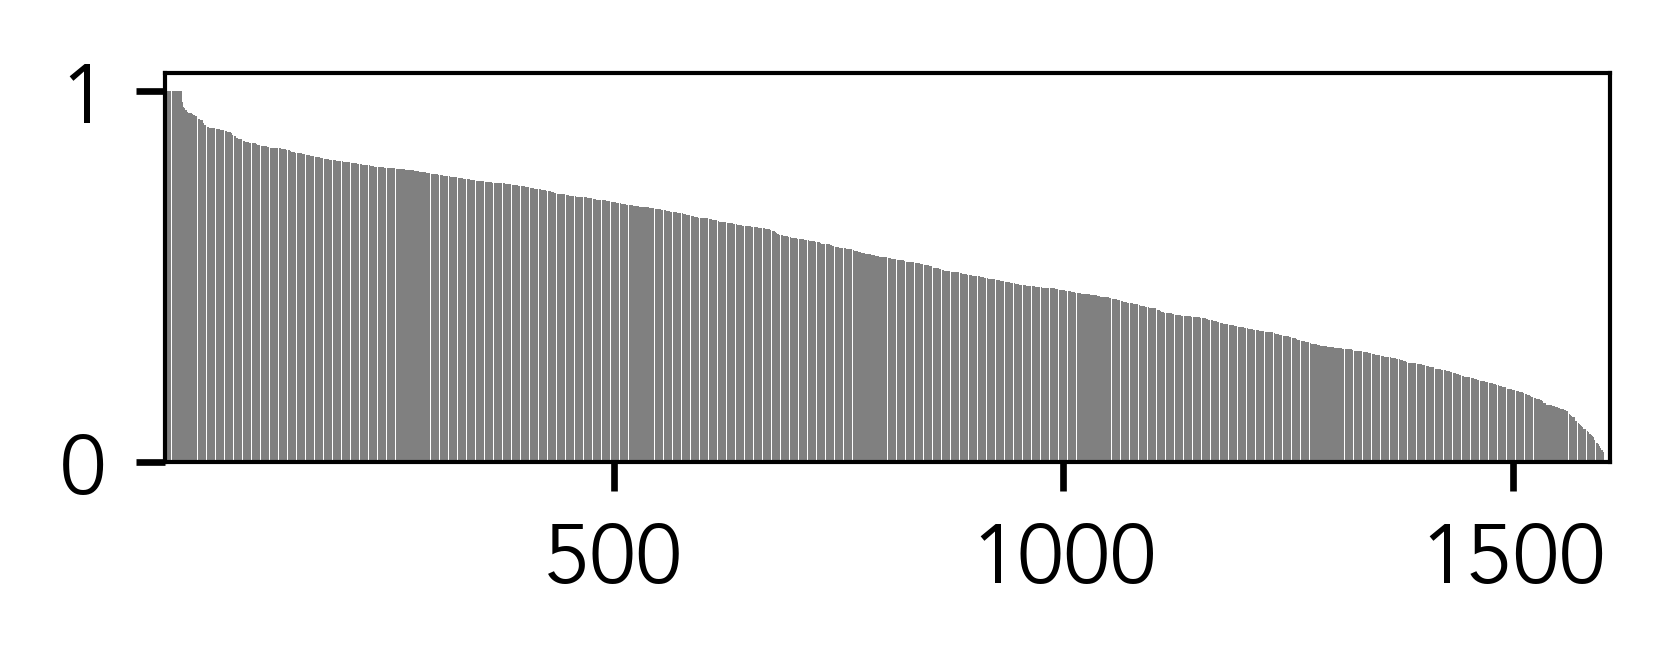

In [10]:
figure(num=None, figsize=(3, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()

idx = np.arange(1,len(fraction_disordered)+1)
plt.bar(idx, fraction_disordered, width=0.9, color='grey')


plt.xlim(1,idx[-1])
plt.tight_layout()
plt.savefig('figures/fraction_disordered_sorted_v2_only.pdf')


### Compute IDR composition
The cell below combines all the IDRs using legacy vs. V2 definition into one single long string (`legacy_idrs` and `new_idrs`) and then from those we can compute the fraction of residues in each class of IDRs.

In [11]:
legacy_idrs = ''
new_idrs = ''

for protein in P:
    for d in protein.domains:
        if d.domain_type == 'IDR':
            new_idrs = new_idrs + d.sequence
        else:
            legacy_idrs = legacy_idrs + d.sequence

## natural amino acids ordered in a physicochemically-cogent way            
AAs = ['A','L','V','I','M','F','Y','W','P','S','G', 'Q','T','N','H','E','D','R','K','C']

new_fractions = {}
legacy_fractions = {}

for aa in AAs:
    new_fractions[aa] = new_idrs.count(aa)/len(new_idrs)
    legacy_fractions[aa] = legacy_idrs.count(aa)/len(legacy_idrs)


#excise from dictionaries into lists with a specific order
new_vals = [new_fractions[i] for i in AAs]
legacy_vals = [legacy_fractions[i] for i in AAs]
        

meta NOT subset; don't know how to subset; dropped


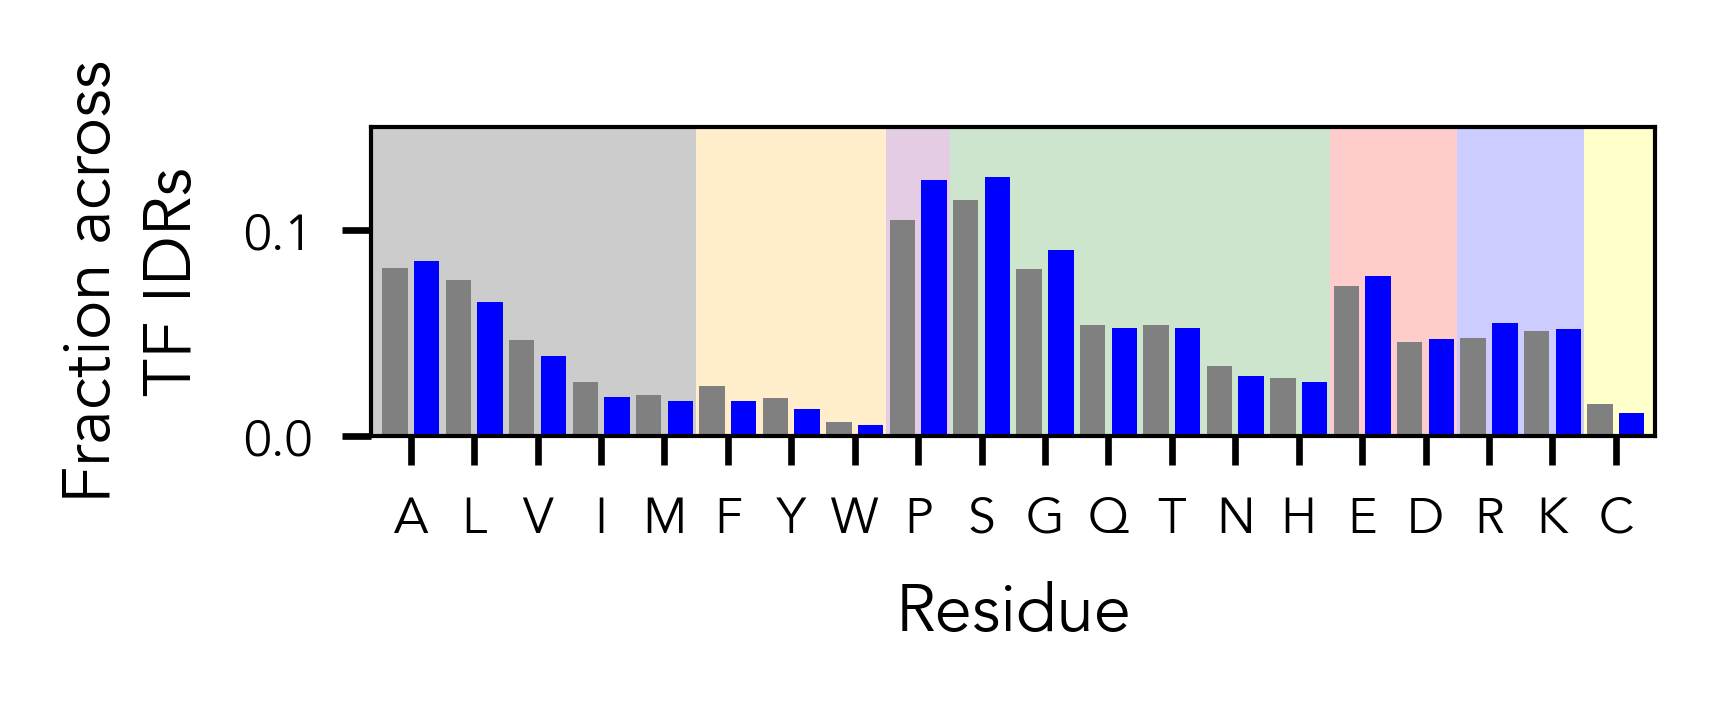

In [12]:
figure(num=None, figsize=(3, 1.2), dpi=300, facecolor='w', edgecolor='k')
ax = plt.gca()


plt.bar(np.arange(1,41,2),new_vals, color='grey')
plt.bar(np.arange(2,42,2),legacy_vals, color='blue')
plt.xticks(np.arange(1.5,41.5,2),AAs,fontsize=6)
plt.ylim([0,0.15])
plt.yticks(fontsize=6)
plt.xlim([0.25,40.75])
plt.xlabel('Residue',fontsize=8)
plt.ylabel('Fraction across\nTF IDRs',fontsize=8)
print('')
plt.axvspan(0.25, 10.5,color='k',alpha=0.2,zorder=-100, linewidth=0)
plt.axvspan(10.5, 16.5,color='orange',alpha=0.2,zorder=-100, linewidth=0)
plt.axvspan(16.5, 18.5,color='purple',alpha=0.2,zorder=-100, linewidth=0)
plt.axvspan(18.5, 30.5,color='green',alpha=0.2,zorder=-100, linewidth=0)
plt.axvspan(30.5, 34.5,color='red',alpha=0.2,zorder=-100, linewidth=0)
plt.axvspan(34.5, 38.5,color='blue',alpha=0.2,zorder=-100, linewidth=0)
plt.axvspan(38.5, 42.5,color='yellow',alpha=0.2,zorder=-100, linewidth=0)

plt.tight_layout()
plt.savefig('figures/fractional_content.pdf')

